# Word subtokenization

We will use pre-made sub-tokens of the words of imdb dataset to do positive and negative review prediction

## Data download

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/future/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data, info = tfds.load('imdb_reviews/subwords8k', as_supervised=True, with_info=True)

print(type(data))
print(info)

<class 'dict'>
tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/subwords8k/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Uses `tfds.deprecated.text.SubwordTextEncoder` with 8k vocab size
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/Users/future/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=54.72 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    supervised_keys=

## Data preprocessing

Checking random examples of data

In [25]:
rand_sentence = None
rand_label = None

for sntnc in data['train'].take(1):
    sentence, label = sntnc
    rand_sentence = sentence.numpy()
    rand_label = label.numpy()

print(rand_sentence)
print(rand_label)

# Fetching the encoder
dataset_encoder = info.features['text'].encoder

# Decoding the sentence
print(dataset_encoder.decode(rand_sentence))

# Fetching the vocabulary
print(dataset_encoder.subwords)
print(dir(dataset_encoder))
print(dataset_encoder._subword_to_id)

[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975]
0
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in his

2024-01-04 11:53:46.440863: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Hyperparameters

In [27]:
vocab_size = dataset_encoder.vocab_size
embed_size = 16
# max_sentence_length = Not needed this time
num_epochs = 16
batch_size = 64 # Max length of array ?
num_training_examples = 8192 * 2

In [28]:
training_data, testing_data = data['train'], data['test']
training_data = training_data.shuffle(num_training_examples)

training_data = training_data.padded_batch(batch_size)
testing_data = testing_data.padded_batch(batch_size)

In [39]:
# maxLen = 0

# for example in data['train']:
#     sent, _ = example
#     maxLen = max(maxLen, sent.numpy().shape[0])
    
# print(maxLen)

3944


In [50]:
for example in training_data.take(1):
    batch_data, batch_labels = example
    print('The dimensions are batch size, tokenized word after truncation ?')
    print(batch_data.numpy())
    for arr in batch_data.numpy():
        if arr[-1] != 0:
            print(arr)
            print(arr.shape)
            print(dataset_encoder.decode(arr))
    print(batch_data.shape)


The dimensions are batch size, tokenized word after truncation ?
[[  62   27   60 ...    0    0    0]
 [1179   14   27 ...    0    0    0]
 [6349    3    9 ...    0    0    0]
 ...
 [8002 7968  111 ...    0    0    0]
 [5244 4313 7961 ...    0    0    0]
 [5264   21   15 ...    0    0    0]]
[  12   81  641 ... 4423  224 7975]
(1470,)
I really wanted to love this show. I truly, honestly did.<br /><br />For the first time, gay viewers get their own version of the "The Bachelor". With the help of his obligatory "hag" Andra, James, a good looking, well-to-do thirty-something has the chance of love with 15 suitors (or "mates" as they are referred to in the show). The only problem is half of them are straight and James doesn't know this. If James picks a gay one, they get a trip to New Zealand, and If he picks a straight one, straight guy gets $25,000. How can this not be fun?! Take my hand, lets stroll: <br /><br />The most glaring problem with this show is the bachelor himself. James is y

Results of my investigation on the batches have been that:
Each batch is of 64 sentences size , with each batch having different maximum sentence length. Maximum sentence length of each batch is different because after shuffling different batches will have different most lenghty sentences in them. Each batch is padded to that maximum sentence length present in their batch. Thus the training data is a list of numpy arrays of different padded batch sizes as opposed to previous notebook where entire training dataset had length equal to maximum sentence in the entire dataset and rest sentences padded to that maximum sentence.

Another proof of the unequal sized training data arrays is that this time we have not passed input_length = maximum_sentence_length here. So the model is ready to accept input arrays of different lengths. However, Each batch has same length of sentences ie. input arrays. 

## Model Creation

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          130960    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 131105 (512.13 KB)
Trainable params: 131105 (512.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [55]:
hist_data = model.fit(training_data, validation_data=testing_data, epochs = num_epochs)

Epoch 1/16


391/391 [==============================] - 3s 6ms/step - loss: 0.6856 - accuracy: 0.5710 - val_loss: 0.6665 - val_accuracy: 0.5918
Epoch 2/16
391/391 [==============================] - 2s 6ms/step - loss: 0.6126 - accuracy: 0.7297 - val_loss: 0.5623 - val_accuracy: 0.8040
Epoch 3/16
391/391 [==============================] - 3s 7ms/step - loss: 0.4943 - accuracy: 0.8430 - val_loss: 0.4646 - val_accuracy: 0.8565
Epoch 4/16
391/391 [==============================] - 3s 7ms/step - loss: 0.4049 - accuracy: 0.8764 - val_loss: 0.4133 - val_accuracy: 0.8381
Epoch 5/16
391/391 [==============================] - 3s 7ms/step - loss: 0.3430 - accuracy: 0.8984 - val_loss: 0.3671 - val_accuracy: 0.8747
Epoch 6/16
391/391 [==============================] - 3s 8ms/step - loss: 0.3018 - accuracy: 0.9091 - val_loss: 0.3451 - val_accuracy: 0.8762
Epoch 7/16
391/391 [==============================] - 3s 8ms/step - loss: 0.2696 - accuracy: 0.9168 - val_loss: 0.3271 - val_accuracy: 0.8793
Epoch 8/16
391/39

## Plotting data

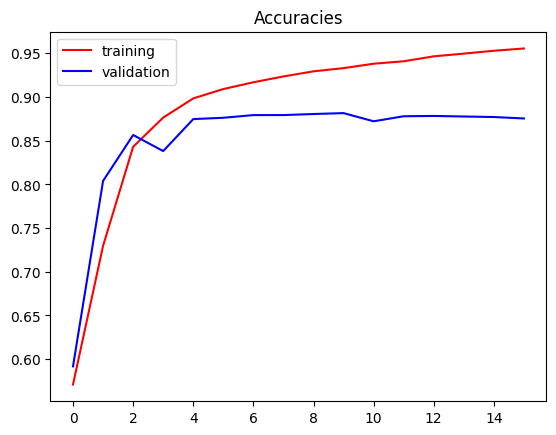

In [56]:
plt.plot(hist_data.history['accuracy'], 'r', label='training')
plt.plot(hist_data.history['val_accuracy'], 'b', label='validation')
plt.legend()
plt.title('Accuracies')
plt.show()

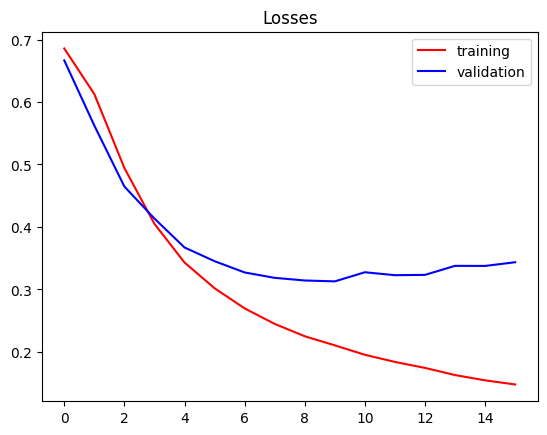

In [57]:
plt.plot(hist_data.history['loss'], 'r', label='training')
plt.plot(hist_data.history['val_loss'], 'b', label='validation')
plt.legend()
plt.title('Losses')
plt.show()

## Random prediction

In [81]:
random_sentence = b'This movie is awesome and bad'
random_sequence = dataset_encoder.encode(random_sentence)
outputs = model.predict([random_sequence])
print(outputs)

if outputs[0] > 0.5:
    print(info.features['label'].names[1],'review')
else:
    print(info.features['label'].names[0],'review')

1/1 [==============================] - 0s 25ms/step
[[0.04373242]]
neg review


In [69]:
print(dir(info.features['label']))
print(info.features['label'].names)

['ALIASES', '__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_additional_repr_info', '_doc', '_dtype', '_dynamic_shape', '_encoded_to_bytes', '_encoding', '_flatten', '_fully_qualified_class_name', '_get_value_and_shape', '_int2str', '_nest', '_num_classes', '_registered_features', '_serialized_dtype', '_serialized_shape', '_set_doc', '_shape', '_str2int', 'catalog_documentation', 'cls_from_name', 'decode_batch_example', 'decode_example', 'decode_example_np', 'decode_ragged_example', 'doc', 'dtype', 'encode_example', 'from_config', 'from_json', 'from_json_content', 'from_proto', 'get_names_filepath', 'get_serialized_info', 'get_tensor_info',

## Visualizing model

In [87]:
# Get the index-word dictionary
# reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 


1
(8185, 16)


In [92]:
dataset_encoder._id_to_subword(3245)

'blin'

In [99]:
import io

# Open writeable files
out_v = io.open('./week2b/vecs_subwords.tsv', 'w', encoding='utf-8')
out_m = io.open('./week2b/meta_subwords.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = dataset_encoder._id_to_subword(word_num-1)

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(str(word_name) + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()